In [1]:
pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 14.5 MB/s 


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# make a fix file size
fixed_size  = tuple((500,500))

#train path 
train_path = "dataset/train"

# no of trees for Random Forests
num_tree = 100

# bins for histograms 
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same result 
seed = 9

In [4]:
# features description -1:  Hu Moments

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [5]:
# feature-descriptor -2 Haralick Texture 

def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

In [6]:
# feature-description -3 Color Histogram

def fd_histogram(image, mask=None):
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histog....
    return hist.flatten()

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [8]:
cd /gdrive/My Drive/Colab Notebooks/carbrandnames

/gdrive/My Drive/Colab Notebooks/carbrandnames


In [9]:
# get the training data labels 
train_labels = os.listdir(train_path)

# sort the training labesl 
train_labels.sort()
print(train_labels)

# empty list to hold feature vectors and labels 
global_features = []
labels = []

i, j = 0, 0 
k = 0

# num of images per class 
images_per_class = 80

['bmw', 'jaguar', 'kia']


In [10]:
# ittirate the folder to get the image label name

%time
# lop over the training data sub folder 

for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
    # loop over the images in each sub-folder
        
    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)
       
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        
        if image is not None:
            image = cv2.resize(image,fixed_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
        #else:
            #print("image not loaded")
                
        #image = cv2.imread(file)        
        #image = cv2.resize(image,fixed_size)

        # Concatenate global features
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1

print("[STATUS] completed Global Feature Extraction...")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
[STATUS] processed folder: bmw
[STATUS] processed folder: jaguar
[STATUS] processed folder: kia
[STATUS] completed Global Feature Extraction...


In [13]:
cd /gdrive/My Drive/Colab Notebooks/carbrandnames/dataset

/gdrive/My Drive/Colab Notebooks/carbrandnames/dataset


In [14]:
%time
import h5py
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...{}")
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('output/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
[STATUS] feature vector size (23, 532)
[STATUS] training Labels (23,)
[STATUS] training labels encoded...{}
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
[STATUS] target labels shape: (23,)
[STATUS] end of training..


In [15]:
# import the feature vector and trained labels

h5f_data = h5py.File('output/data.h5', 'r')
h5f_label = h5py.File('output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

In [16]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

In [17]:
from sklearn.metrics import classification_report
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

#print(clf.fit(trainDataGlobal, trainLabelsGlobal))

clf_pred = clf.predict(trainDataGlobal)
#clf_pred = clf.predict(global_feature.reshape(1,-1))[0]
print(classification_report(trainLabelsGlobal,clf_pred))
#print(confusion_matrix(trainLabelsGlobal,clf_pred))

#print(clf.predict(trainDataGlobal))

#print(clf.predict(global_feature.reshape(1,-1))[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [19]:
cd /gdrive/My Drive/Colab Notebooks/carbrandnames/dataset

/gdrive/My Drive/Colab Notebooks/carbrandnames/dataset


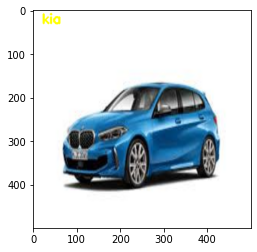

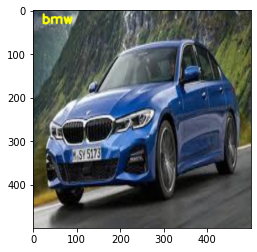

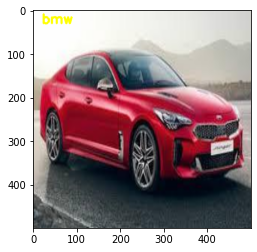

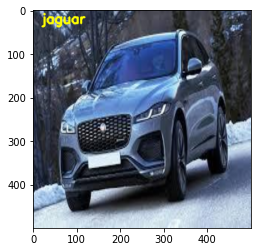

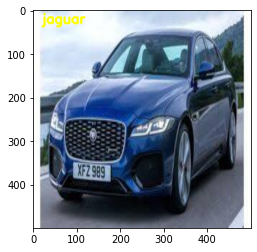

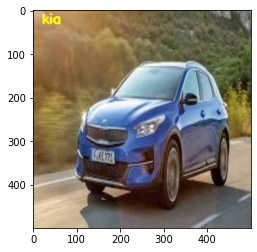

In [21]:
# path to test data
test_path = "test"

# loop through the test images
#for file in glob.glob(test_path + "/*.jpg"):
for file in os.listdir(test_path):    

    file = test_path + "/" + file
    #print(file)
    
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    # Global Feature extraction
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    # Concatenate global features

    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()